Data Importing

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


Data Loading and inspecting

In [2]:
import pandas as pd

df = pd.read_excel('Online Retail.xlsx')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Data Cleaning

In [3]:
# Remove missing customer IDs
df = df[df['CustomerID'].notnull()]

In [4]:
# Remove negative or zero quantities
df = df[df['Quantity'] > 0]


In [5]:
# Remove invalid prices
df = df[df['UnitPrice'] > 0]

In [6]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


<ipython-input-6-e488188f0e4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [7]:
# Reset index
df.reset_index(drop=True, inplace=True)

RFM Feature Engineering

In [8]:
import datetime as dt

# Set reference date as one day after the last invoice date
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create the RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,     # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'UnitPrice': lambda x: round((x * df.loc[x.index, 'Quantity']).sum(), 2)  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Preview RFM table
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Removing Outliers(with negative monetary value)

In [9]:
# Keep only customers with positive monetary value
rfm = rfm[rfm['Monetary'] > 0]

# (Optional) Remove extreme outliers for stable clustering
rfm = rfm[rfm['Recency'] < rfm['Recency'].quantile(0.95)]
rfm = rfm[rfm['Monetary'] < rfm['Monetary'].quantile(0.95)]
rfm = rfm[rfm['Frequency'] < rfm['Frequency'].quantile(0.95)]

rfm.reset_index(inplace=True)
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,4310.00
1,12348.0,75,4,1797.24
2,12349.0,19,1,1757.55
3,12350.0,310,1,334.40
4,12352.0,36,8,2506.04


RFM Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

# Store original for later visualization
rfm_original = rfm.copy()

# Normalize the RFM columns
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


  Number of Clusters using:- Elbow Method

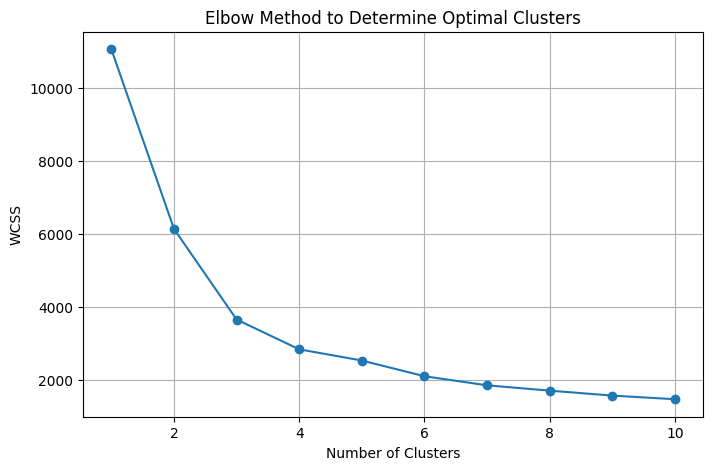

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


K-Means Clustering

In [12]:
# Let's assume 4 clusters from elbow method
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [13]:
# Average RFM per cluster
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,34.19,6.42,3151.71
1,50.80,1.67,485.61
2,221.14,1.53,435.92
3,41.21,4.47,1345.81


2D Scatter Plots for Cluster Patterns

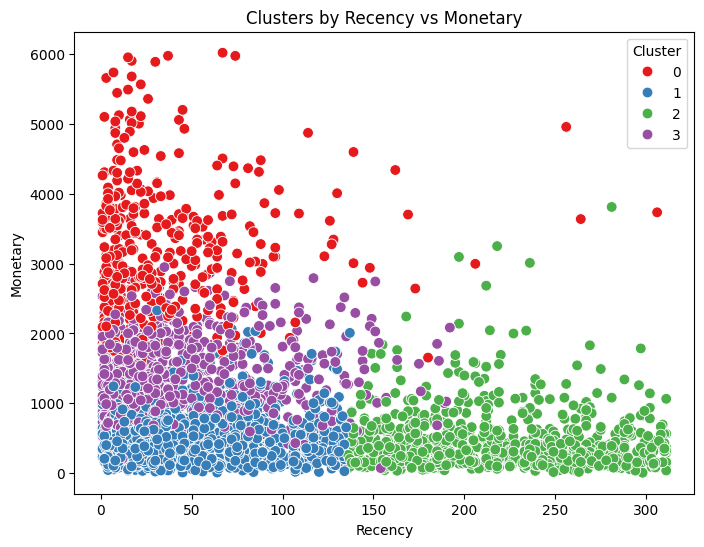

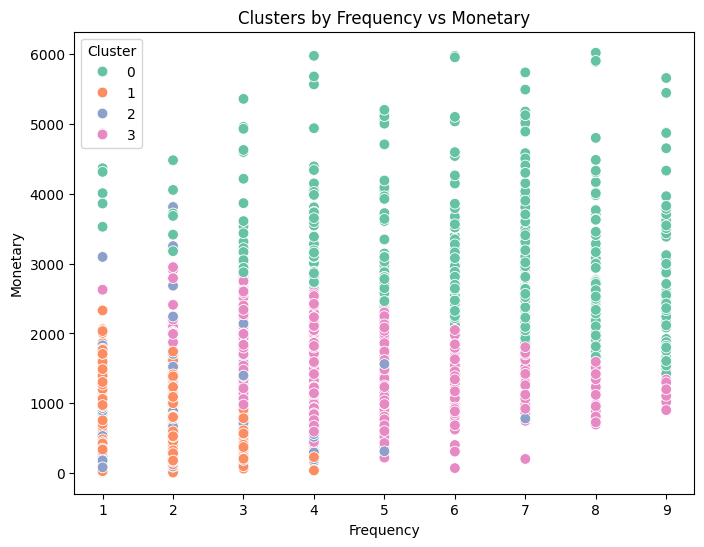

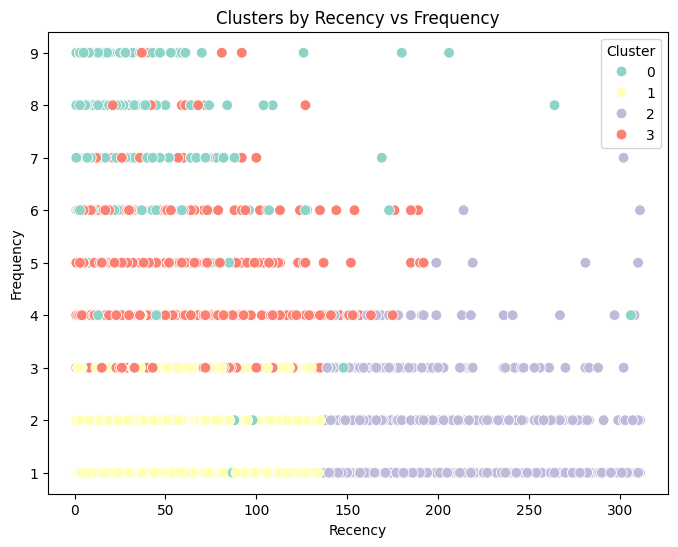

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Recency vs Monetary
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1', s=60)
plt.title('Clusters by Recency vs Monetary')
plt.show()

# Plot Frequency vs Monetary
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', s=60)
plt.title('Clusters by Frequency vs Monetary')
plt.show()

# Plot Recency vs Frequency
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set3', s=60)
plt.title('Clusters by Recency vs Frequency')
plt.show()


In [15]:
# Group by cluster and calculate average RFM values- View Cluster Summary
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,34.19,6.42,3151.71
1,50.80,1.67,485.61
2,221.14,1.53,435.92
3,41.21,4.47,1345.81


In [16]:
# Define new labels for clarity
def assign_cluster_label(row):
    if row['Cluster'] == 0:
        return 'Churned Customers'
    elif row['Cluster'] == 1:
        return 'Loyal Customers'
    elif row['Cluster'] == 2:
        return 'Potential Loyalists'
    else:
        return 'New Customers'

# Create a new column for segment name
rfm['Segment'] = rfm.apply(assign_cluster_label, axis=1)

# Preview
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']].head()


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12347.0,2,7,4310.00,0,Churned Customers
1,12348.0,75,4,1797.24,3,New Customers
2,12349.0,19,1,1757.55,1,Loyal Customers
3,12350.0,310,1,334.40,2,Potential Loyalists
4,12352.0,36,8,2506.04,0,Churned Customers


Frequency count of each segment

In [17]:
rfm['Segment'].value_counts()


,count
Segment,
Loyal Customers,1561
New Customers,878
Potential Loyalists,851
Churned Customers,394


Count & Revenue per Segment

In [18]:
# Number of customers in each segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'CustomerCount']
print(segment_counts)

# Total revenue (Monetary) from each segment
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().reset_index().sort_values(by='Monetary', ascending=False)
segment_revenue.columns = ['Segment', 'TotalRevenue']
print(segment_revenue)


               Segment  CustomerCount
0      Loyal Customers           1561
1        New Customers            878
2  Potential Loyalists            851
3    Churned Customers            394
               Segment  TotalRevenue
0    Churned Customers    1241774.47
2        New Customers    1181621.61
1      Loyal Customers     758036.42
3  Potential Loyalists     370970.29


Average RFM Metrics by Segment

In [19]:
# Average RFM metrics for each segment
avg_rfm_by_segment = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(2).reset_index()
print(avg_rfm_by_segment)


               Segment  Recency  Frequency  Monetary
0    Churned Customers    34.19       6.42   3151.71
1      Loyal Customers    50.80       1.67    485.61
2        New Customers    41.21       4.47   1345.81
3  Potential Loyalists   221.14       1.53    435.92


Customer Lifetime Value (Simplified Proxy)

In [20]:
# CLV = Frequency × Monetary
rfm['CLV'] = rfm['Frequency'] * rfm['Monetary']

# Average CLV per segment
clv_by_segment = rfm.groupby('Segment')['CLV'].mean().round(2).reset_index().sort_values(by='CLV', ascending=False)
print(clv_by_segment)


               Segment       CLV
0    Churned Customers  19692.25
2        New Customers   5942.77
1      Loyal Customers    885.14
3  Potential Loyalists    784.79


In [ ]:
# Export enhanced data for Power BI dashboard
rfm.to_csv('Enhanced_RFM_Segmentation.csv', index=False)
